_python notebook №2_

## Стадия обученяи сетей ResNet18 с применением Transfer learning

In [1]:
#pip install nbimporter

In [1]:
import nbimporter
import datasets_bilder # загрузка datasets_bilder.py из репозитория

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import seaborn as sns
import torch,torchvision
from  matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import torchvision.utils as vutils
%matplotlib inline

In [3]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [4]:
print('В репозитории находятся следующие файлы:', os.listdir())

В репозитории находятся следующие файлы: ['.git', '.gitignore', '.ipynb_checkpoints', 'chest_xray', 'datasets_bilder.py', 'models', 'Preprocessing_&_custom_DL_model.ipynb', 'Transfer_learning_ResNet_training.ipynb', '__pycache__']


Для реализации предобработки данных я написал отельный файл datasets_bilder.py в котором описал создание класса preprocessing_func, который в методе init генерит 3 датасета: dataset_test, dataset_train, dataset_test и сохраняет их значения в атрибутах test, train, val объекта класса. Атрибуты mean_nums и std_nums дают возможность получить величины средних значений и ско для всего train датасета. <br><br>
По сути данный код является полной копией кода из файла Preprocessing_&_custom_DL_model.ipynb, но только представленным в виде функции инициализации объекта класса. Так что для ознакомления с реализацией предобработки советую рассмотреть тот python notebook.<br> <br>
Единственным важным дополнением в предобработке, представленной в файле datasets_bilder.py, можно назвать возможность выбора размерности данных, которые мы хотим получать на выходе. Если при задании объекта класса указать значение size, то можно самому выбрать размер получаемых после трасформации Resize изображений (по умолчанию - квадратные изображения размером 224 на 224). <br>Так же если ввести при задании объекта значение RGB_presentation = True, то выходной размер изображений станет равен (3, Size, Size) вместо классического для чб снимков тензора размером (1, Size, Size). По умолчанию RGB_presentation = False. Данная функция будет нужна при Transfer Learning, так как предобученные сети имеют первый сверточный слой трехканальным, так что для использования готовых сетей можно просто сделать дублирование одного канала еще 2 раза чтобы изображение черно-белое можно было считать цветным. При выборе RGB_presentation = True тензоры, хранящиеся в атрибутах mean_nums и std_nums тоже меняют размерность
<br> Параметр easy = True позволяет трейновый датасет сделать размером 5370 изображений (применяется 2 трансформации вместо 4) По умолчанию параметр стоит False => 10740 изображений

__Пример работы с preprocessing_func:__

In [29]:
data = datasets_bilder.preprocessing_func(size = 100, RGB_presentation = True)

In [30]:
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums

In [31]:
mean_nums, std_nums

(tensor([0.5455, 0.5455, 0.5455]), tensor([0.2587, 0.2587, 0.2587]))

In [32]:
a, _ = dataset_test[0]
a.shape

torch.Size([3, 100, 100])

Зададим вычислительное устройство:

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [52]:
batch_size = 8 # зададим размер батча

Проверим правильность загруженных данных:

In [4]:
def imshow(img):
    img = img *std_nums[0] + mean_nums[0]  
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    plt.show()

In [59]:
dataloader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test:


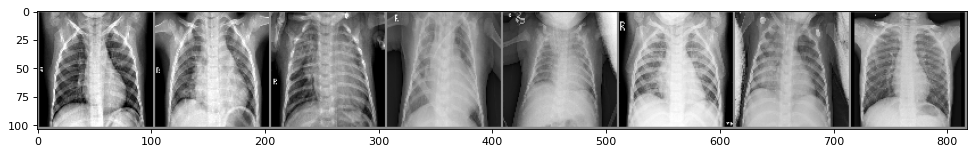

GroundTruth:  norm,  pneumonia,  pneumonia,  pneumonia,  pneumonia,  norm,  pneumonia,  norm


In [60]:
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(dataloader_test))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)
print('test:')
plt.figure(figsize=(15, 9), dpi=80)
# выводим изображения в батче
imshow(torchvision.utils.make_grid(image_batch, nrow=8))
print('GroundTruth: ', ',  '.join( classes[int(label_batch[j])] for j in range(batch_size)))

Функция для визуализации confusion_matrix:

In [6]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## ResNet18

Загрузим предобученную модель. У нее входной первый сверточный слой является трехканальным размером 224 на 224 пикселя. Сама сетка имеет 18 слоев.

In [7]:
from torchvision.models import resnet18, ResNet18_Weights

In [110]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

У данной сети представлен лишь 1 слой полносвязный под названием fc с выходным числом нейронов равным 1000. В нашем случае решается задача бинарной классификации, так что данный слой будет иметь по 2 нейрона на выходе.

## _Рассмотрим какие эксперименты мы будем проводить с данной сетью:_

__1) Зафиксируем полностью все сверточные слои и лишь обучим полносвязные слои.__ <br>При этом я поменяю архитектуру полносвязного слоя fc. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра.  Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

__2) Зафиксируем все сверточные слои кроме первого входного, в котором установим число входных каналов равным 1 вместо 3 + обучим полносвязные слои.__<br>
При этом я поменяю архитектуру полносвязного слоя fc. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как я поменяю чило каналов на входе сети, поэтому могу обучать на чб снимках, размером (1, 224, 224).


__3) Полностью обучим сеть, ничего в ней не меняя (кроме выходного числа нейронов в полносвязной части).__<br>
Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

## №1

In [55]:
data = datasets_bilder.preprocessing_func(RGB_presentation = True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums

In [ ]:
n_neurons = 100

In [ ]:
# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2))

In [113]:
model.fc = fc_new
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [119]:
# Зафиксируем все слои кроме переназначенного fc
for name, param in model.named_parameters():
    if not ('fc' in name):
        param.requires_grad = False

Опишем такие же прарметры обучения как в python notebook №1:

In [120]:
loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

opt = optim.Adam(model.parameters(), lr=0.001) # Адам-оптимизатор
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

Создадим папку, куда загрузим модели:

In [122]:
directory = os.getcwd() + '\models'
if not os.path.exists(directory):
    os.makedirs(directory)

Сделаем тренировочный запуск обучения без подбора гиперпараметров. Сам принцип кода по обучению такой же, как был при обучении кастомной нейросетки в прошлом ноутбуке №1

In [123]:
n_epoch = 2 #Зададим число эпох обучения
batch_size = 10 #Размер батча

In [145]:
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [127]:
# Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
loss_train = []
acc_train = []
acc_validation = []
loss_validation = []

model.train() # Перевод модели в режим обучения
start_time = time.time()
maxacc = 0 
for epoch in range(n_epoch): # цикл эпох
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for batch in tqdm(train_dataloader):
        # получим данные батча
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        #Приведу значение label_batch к требуемому виду
        label_batch = torch.flatten(label_batch).type(torch.LongTensor) 
        
        # обнуление параметров градиента
        opt.zero_grad()

        # forward + backward + optimize
        y_pred = model(image_batch)
        loss = loss_func(y_pred, label_batch)
        
        loss.backward()
        opt.step()
        
        #среднее по так будем искать (складывать а потом делить число батчей):
        running_loss += loss.item() 
        running_acc += accuracy(y_pred, label_batch)
        
    print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                      running_acc / len(train_dataloader)))
    loss_train.append(running_loss / len(train_dataloader))
    acc_train.append(running_acc / len(train_dataloader))
    scheduler.step() # шаг для lr_scheduler

    model.eval()  #Перевод модели в режим тестирования
    acc_val = []
    running_loss_val = 0
    for itr,data in enumerate(val_dataloader):
            imgs = data[0].to(device)
            labels = data[1].to(device)   
            labels = torch.flatten(labels).type(torch.LongTensor)
            y_pred = model(imgs)
            acc_val.append(accuracy(y_pred,labels))
            running_loss_val += loss.item()
    loss_val_ep =  running_loss_val / len(val_dataloader)

    acc_val_ep = np.mean(np.array(acc_val))
    print(f'Validation accuracy - {acc_val_ep}')
    acc_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)

    
    # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
    if np.mean(np.array(acc_val)) > maxacc:
            maxacc = np.mean(np.array(acc_val)) 
            torch.save(model, directory+'\model_TransferLearning.pth')
            
print('Total time {:.3f} seconds'.format(time.time() - start_time))


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [46:48<00:00,  2.62s/it]


[epoch 1] loss: 0.387, acc: 0.825
Validation accuracy - 0.878125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [46:43<00:00,  2.61s/it]


[epoch 2] loss: 0.368, acc: 0.839
Validation accuracy - 0.8999999999999999
Total time 5752.861 seconds


In [133]:
wghts = torch.load(directory + '/model_TransferLearning.pth')
model.load_state_dict(wghts.state_dict())

<All keys matched successfully>

In [147]:
model.eval()
y_true_list = []
y_pred_list = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        y_true_list.append(label_batch.numpy())
        y_pred_list.append(predicted.numpy())
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 86.88 %


In [137]:
y_pred_list = np.asarray(y_pred_list).flatten()
y_true_list = np.asarray(y_true_list).flatten()
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       129
           1       0.90      0.87      0.89       191

    accuracy                           0.87       320
   macro avg       0.86      0.87      0.86       320
weighted avg       0.87      0.87      0.87       320



Получили довольно высокие результаты всего лишь при двух эпохах обучения.<br>

---

__Теперь проведем обучение 10 эпох для каждого значения подбираемого гиперпараметра:__

Я сделаю один скрытый слой в новом fc layer с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определю по результатам accuracy на валидационной выборке + построю графики изменения метрик accuracy и loss в процессе обучения для каждого значения гиперпараметра. <br> Значения пербираемые n_neurons = 10, 100 и 500

In [56]:
n_neurons_list = [10, 100, 500]

Размер батча возьмем для данного обучения побольше. Пусть он равен 30 изображениям. Тогда 1 эпоха равносильна 179 градиентным спускам

In [116]:
data = datasets_bilder.preprocessing_func(RGB_presentation=True, easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 30
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [60]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [61]:
# Задаим словари для отслеживания метрик accuracy и loss в процессе обучения для каждого значения гиперпараметра.
loss_train_dict = {}
acc_train_dict = {}
acc_validation_dict = {}
loss_validation_dict = {}

n_epoch = 10 #Зададим число эпох обучения
start_time = time.time()
for n_neurons in n_neurons_list:
    model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
    # Переопредлим полносвязные слои:
    fc_new =  nn.Sequential(
                nn.Linear(512, n_neurons),
                nn.ReLU(),
                nn.Linear(n_neurons, 2))
    model.fc = fc_new
    # Зафиксируем все слои кроме переназначенного fc
    for name, param in model.named_parameters():
        if not ('fc' in name):
            param.requires_grad = False
    
    loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

    opt = optim.Adam(model.parameters(), lr=0.001) # Адам-оптимизатор
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)
    
    # Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
    loss_train = []
    acc_train = []
    acc_validation = []
    loss_validation = []
    
    
    maxacc = 0 
    print('НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons, ':')
    for epoch in range(n_epoch): # цикл эпох
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        for batch in tqdm(train_dataloader):
            # получим данные батча
            image_batch, label_batch  = batch
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            #Приведу значение label_batch к требуемому виду
            label_batch = torch.flatten(label_batch).type(torch.LongTensor) 

            # обнуление параметров градиента
            opt.zero_grad()

            # forward + backward + optimize
            y_pred = model(image_batch)
            loss = loss_func(y_pred, label_batch)

            loss.backward()
            opt.step()

            #среднее по так будем искать (складывать а потом делить число батчей):
            running_loss += loss.item() 
            running_acc += accuracy(y_pred, label_batch)

        print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                          running_acc / len(train_dataloader)))
        loss_train.append(running_loss / len(train_dataloader))
        acc_train.append(running_acc / len(train_dataloader))
        scheduler.step() # шаг для lr_scheduler

        model.eval()  #Перевод модели в режим тестирования
        acc_val = []
        running_loss_val = 0
        for itr,data in enumerate(val_dataloader):
                imgs = data[0].to(device)
                labels = data[1].to(device)   
                labels = torch.flatten(labels).type(torch.LongTensor)
                y_pred = model(imgs)
                acc_val.append(accuracy(y_pred,labels))
                running_loss_val += loss.item()
        loss_val_ep =  running_loss_val / len(val_dataloader)

        acc_val_ep = np.mean(np.array(acc_val))
        print(f'Validation accuracy - {acc_val_ep}')
        acc_validation.append(acc_val_ep)
        loss_validation.append(loss_val_ep)


        # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
        if np.mean(np.array(acc_val)) > maxacc:
                maxacc = np.mean(np.array(acc_val)) 
                torch.save(model, directory+'\model_ResNet18_1_n='+str(n_neurons)+'.pth')
                
    print('ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons)    
    
    # Добавим в словари значения изменения метрик в процессе обучения для текущего значения гиперпараметра
    loss_train_dict[n_neurons] = loss_train
    acc_train_dict[n_neurons] = acc_train
    acc_validation_dict[n_neurons] = acc_validation
    loss_validation_dict[n_neurons] = loss_validation
        
print('Total time {:.1f} seconds'.format(time.time() - start_time))

НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:58<00:00,  7.70s/it]


[epoch 1] loss: 0.279, acc: 0.898
Validation accuracy - 0.8787878787878788


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:35<00:00,  7.57s/it]


[epoch 2] loss: 0.174, acc: 0.933
Validation accuracy - 0.8924242424242425


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:38<00:00,  7.59s/it]


[epoch 3] loss: 0.165, acc: 0.936
Validation accuracy - 0.8590909090909092


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:40<00:00,  7.60s/it]


[epoch 4] loss: 0.156, acc: 0.938
Validation accuracy - 0.8893939393939394


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:36<00:00,  7.58s/it]


[epoch 5] loss: 0.145, acc: 0.944
Validation accuracy - 0.8757575757575758


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:42<00:00,  7.61s/it]


[epoch 6] loss: 0.125, acc: 0.955
Validation accuracy - 0.8636363636363638


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:42<00:00,  7.61s/it]


[epoch 7] loss: 0.122, acc: 0.954
Validation accuracy - 0.8575757575757575


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:43<00:00,  7.62s/it]


[epoch 8] loss: 0.12, acc: 0.958
Validation accuracy - 0.8636363636363636


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:41<00:00,  7.61s/it]


[epoch 9] loss: 0.118, acc: 0.957
Validation accuracy - 0.8621212121212121


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:44<00:00,  7.62s/it]


[epoch 10] loss: 0.117, acc: 0.957
Validation accuracy - 0.8590909090909092
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:42<00:00,  7.61s/it]


[epoch 1] loss: 0.242, acc: 0.899
Validation accuracy - 0.8393939393939395


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:38<00:00,  7.59s/it]


[epoch 2] loss: 0.18, acc: 0.93
Validation accuracy - 0.8318181818181817


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:41<00:00,  7.60s/it]


[epoch 3] loss: 0.155, acc: 0.939
Validation accuracy - 0.8393939393939395


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:40<00:00,  7.60s/it]


[epoch 4] loss: 0.141, acc: 0.943
Validation accuracy - 0.8303030303030302


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:40<00:00,  7.60s/it]


[epoch 5] loss: 0.13, acc: 0.95
Validation accuracy - 0.8484848484848485


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:43<00:00,  7.62s/it]


[epoch 6] loss: 0.107, acc: 0.961
Validation accuracy - 0.881818181818182


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:44<00:00,  7.62s/it]


[epoch 7] loss: 0.109, acc: 0.958
Validation accuracy - 0.8424242424242425


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:43<00:00,  7.62s/it]


[epoch 8] loss: 0.109, acc: 0.96
Validation accuracy - 0.8621212121212121


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:45<00:00,  7.63s/it]


[epoch 9] loss: 0.11, acc: 0.956
Validation accuracy - 0.8515151515151516


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:47<00:00,  7.64s/it]


[epoch 10] loss: 0.105, acc: 0.961
Validation accuracy - 0.8469696969696969
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:44<00:00,  7.62s/it]


[epoch 1] loss: 0.246, acc: 0.897
Validation accuracy - 0.9045454545454547


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:46<00:00,  7.64s/it]


[epoch 2] loss: 0.162, acc: 0.938
Validation accuracy - 0.8696969696969699


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:46<00:00,  7.63s/it]


[epoch 3] loss: 0.152, acc: 0.942
Validation accuracy - 0.9045454545454544


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:48<00:00,  7.64s/it]


[epoch 4] loss: 0.128, acc: 0.952
Validation accuracy - 0.8651515151515151


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:48<00:00,  7.64s/it]


[epoch 5] loss: 0.137, acc: 0.943
Validation accuracy - 0.8363636363636364


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:49<00:00,  7.65s/it]


[epoch 6] loss: 0.101, acc: 0.963
Validation accuracy - 0.8636363636363638


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:48<00:00,  7.65s/it]


[epoch 7] loss: 0.0915, acc: 0.964
Validation accuracy - 0.856060606060606


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:46<00:00,  7.63s/it]


[epoch 8] loss: 0.0869, acc: 0.967
Validation accuracy - 0.8560606060606062


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:47<00:00,  7.64s/it]


[epoch 9] loss: 0.0936, acc: 0.965
Validation accuracy - 0.8606060606060608


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [22:46<00:00,  7.63s/it]


[epoch 10] loss: 0.0816, acc: 0.97
Validation accuracy - 0.8621212121212122
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500
Total time 42984.6 seconds


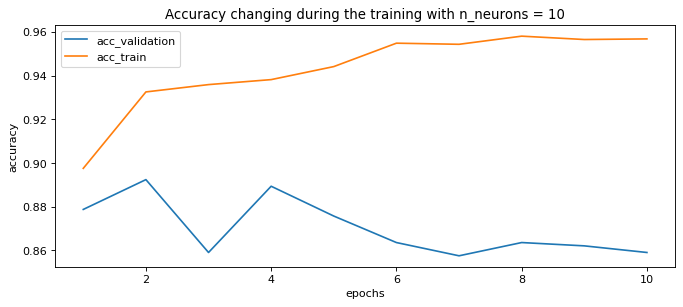

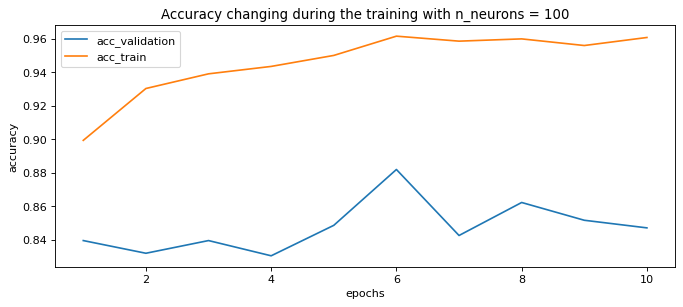

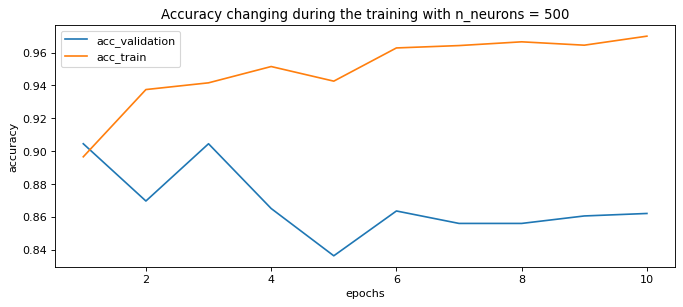

In [62]:
for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    acc_train = acc_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Accuracy changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')  
    plt.show()

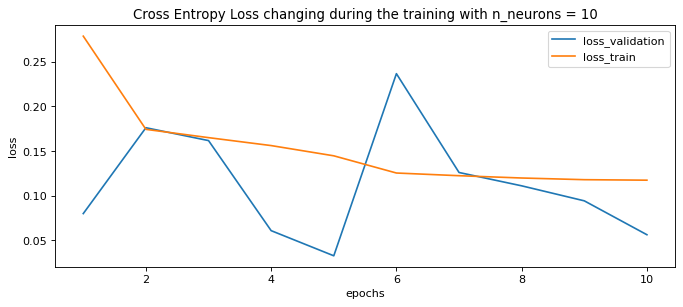

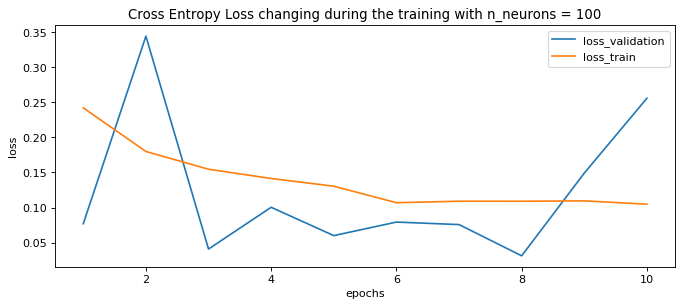

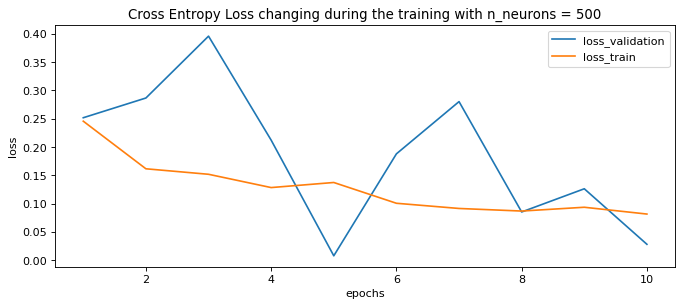

In [63]:
for i in n_neurons_list:
    loss_validation = loss_validation_dict[i]
    loss_train = loss_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Cross Entropy Loss changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
    plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='best')  
    plt.show()

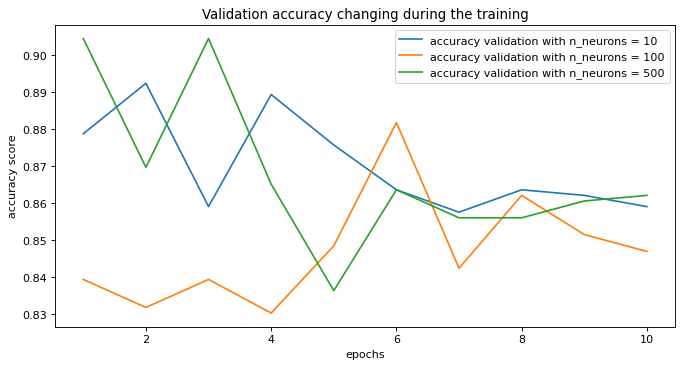

In [64]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title('Validation accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

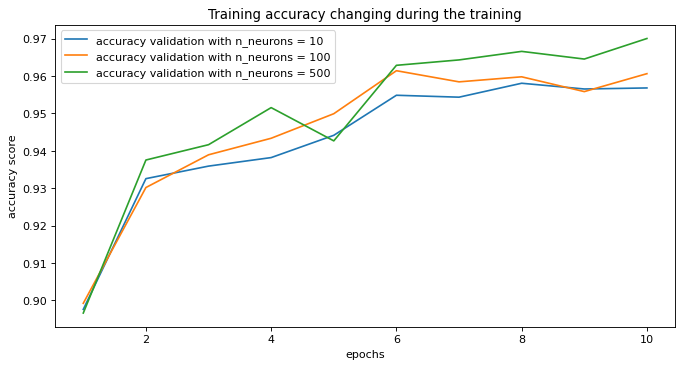

In [65]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title('Training accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_train = acc_train_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

In [66]:
table = [list(range(1,n_epoch+1))]
columns = ['epoch']
for i, val in enumerate(n_neurons_list):
    table.append(acc_validation_dict[val])
    columns.append(str(val)+' neurons')
table = np.asarray(table).T
print('Validation accuracy change:')
pd.DataFrame(table, columns=columns)

Validation accuracy change:


,epoch,10 neurons,100 neurons,500 neurons
0,1.0,0.878788,0.839394,0.904545
1,2.0,0.892424,0.831818,0.869697
2,3.0,0.859091,0.839394,0.904545
3,4.0,0.889394,0.830303,0.865152
4,5.0,0.875758,0.848485,0.836364
5,6.0,0.863636,0.881818,0.863636
6,7.0,0.857576,0.842424,0.856061
7,8.0,0.863636,0.862121,0.856061
8,9.0,0.862121,0.851515,0.860606
9,10.0,0.859091,0.846970,0.862121


In [67]:
acc_validation_dict_1 = acc_validation_dict
acc_train_dict_1 = acc_train_dict

Самый высокий показатель accuracy на валидации показал гиперпараметр 500 на 3 эпохе обучения. Так что загрузим именно эту модель:

In [117]:
n_neurons = 500
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
                nn.Linear(512, n_neurons),
                nn.ReLU(),
                nn.Linear(n_neurons, 2))
model.fc = fc_new
wghts = torch.load(directory + '\model_ResNet18_1_n='+str(n_neurons)+'.pth')
model.load_state_dict(wghts.state_dict())

<All keys matched successfully>

Оценим качество этой модели на test:

In [118]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        if i==0:
            y_true_list = label_batch.numpy()
            y_pred_list = predicted.numpy()
        else:
        
            y_true_list = np.concatenate([y_true_list, label_batch.numpy()])
            y_pred_list = np.concatenate([y_pred_list, predicted.numpy()])
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 88.44 %


In [119]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       129
           1       0.92      0.88      0.90       191

    accuracy                           0.88       320
   macro avg       0.88      0.88      0.88       320
weighted avg       0.89      0.88      0.88       320



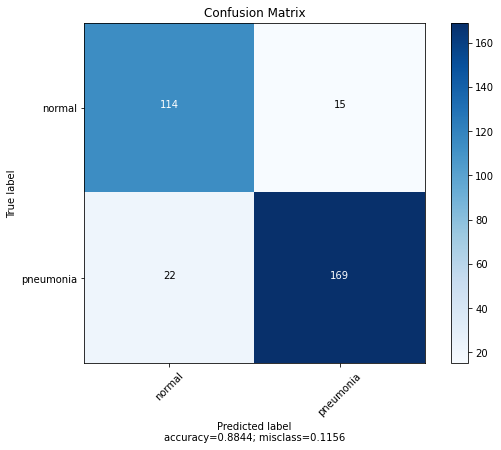

In [120]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['normal','pneumonia'],
                      title        = "Confusion Matrix")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


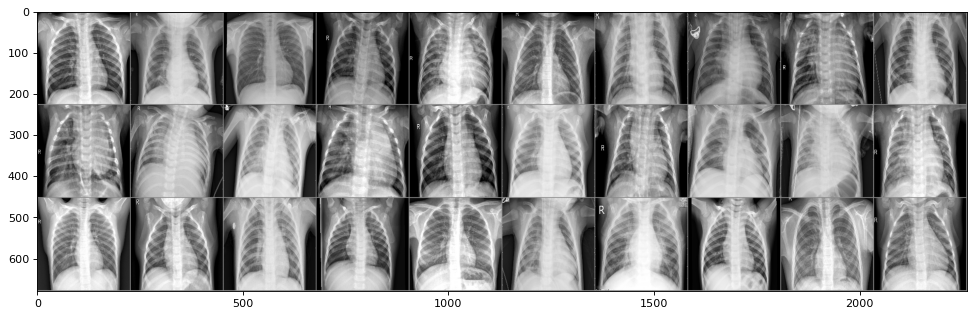

GroundTruth:   norm pneumonia  norm  norm pneumonia  norm  norm pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia  norm  norm pneumonia pneumonia pneumonia pneumonia  norm  norm pneumonia  norm  norm pneumonia pneumonia  norm  norm  norm
Прогноз:  norm pneumonia norm norm pneumonia norm pneumonia pneumonia pneumonia pneumonia norm pneumonia pneumonia norm norm pneumonia pneumonia pneumonia pneumonia pneumonia norm norm pneumonia norm norm pneumonia pneumonia norm norm norm


In [121]:
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(test_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ' '.join('%5s' % classes[int(label_batch[j])] for j in range(batch_size)))
outputs = model(image_batch)
predicted = torch.argmax(outputs, dim=1)

print('Прогноз: '," ".join(classes[predicted[j]]for j in range(batch_size)))

---

## №2

__Зафиксируем все сверточные слои кроме первого входного, в котором установим число входных каналов равным 1 вместо 3 + обучим полносвязные слои.__<br>
При этом я поменяю архитектуру полносвязного слоя fc. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как я поменяю чило каналов на входе сети, поэтому могу обучать на чб снимках, размером (1, 224, 224).


In [98]:
data = datasets_bilder.preprocessing_func(easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 30 
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [99]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [100]:
n_neurons_list = [10, 100, 500]

In [101]:
loss_train_dict = {}
acc_train_dict = {}
acc_validation_dict = {}
loss_validation_dict = {}

n_epoch = 10 #Зададим число эпох обучения
start_time = time.time()
for n_neurons in n_neurons_list:
    model_2 = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
    # Переопределим первый сверточный слой сети, сделав 1 входной канал
    model_2.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # Переопредлим полносвязные слои:
    fc_new =  nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(512, n_neurons),
                nn.ReLU(),
                nn.Linear(n_neurons, 2))
    model_2.fc = fc_new
    
    loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

    opt = optim.Adam(model_2.parameters(), lr=0.001) # Адам-оптимизатор
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)
    
    
    # Зафиксируем все слои кроме переназначенного fc  и conv1
    for name, param in model_2.named_parameters():
        if not (('conv1' in name) or ('fc' in name)):
            param.requires_grad = False

    # Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
    loss_train = []
    acc_train = []
    acc_validation = []
    loss_validation = []

    maxacc = 0 
    print('НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons, ':')
    for epoch in range(n_epoch): # цикл эпох
        model_2.train()
        running_loss = 0.0
        running_acc = 0.0
        for batch in tqdm(train_dataloader):
            # получим данные батча
            image_batch, label_batch  = batch
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            #Приведу значение label_batch к требуемому виду
            label_batch = torch.flatten(label_batch).type(torch.LongTensor) 

            # обнуление параметров градиента
            opt.zero_grad()

            # forward + backward + optimize
            y_pred = model_2(image_batch)
            loss = loss_func(y_pred, label_batch)

            loss.backward()
            opt.step()

            #среднее по так будем искать (складывать а потом делить число батчей):
            running_loss += loss.item() 
            running_acc += accuracy(y_pred, label_batch)

        print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                          running_acc / len(train_dataloader)))
        loss_train.append(running_loss / len(train_dataloader))
        acc_train.append(running_acc / len(train_dataloader))
        scheduler.step() # шаг для lr_scheduler

        model_2.eval()  #Перевод модели в режим тестирования
        acc_val = []
        running_loss_val = 0
        for itr,data in enumerate(val_dataloader):
                imgs = data[0].to(device)
                labels = data[1].to(device)   
                labels = torch.flatten(labels).type(torch.LongTensor)
                y_pred = model_2(imgs)
                acc_val.append(accuracy(y_pred,labels))
                running_loss_val += loss.item()
        loss_val_ep =  running_loss_val / len(val_dataloader)

        acc_val_ep = np.mean(np.array(acc_val))
        print(f'Validation accuracy - {acc_val_ep}')
        acc_validation.append(acc_val_ep)
        loss_validation.append(loss_val_ep)


        # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
        if np.mean(np.array(acc_val)) > maxacc:
                maxacc = np.mean(np.array(acc_val)) 
                torch.save(model_2, directory+'\model_ResNet18_2_n='+str(n_neurons)+'.pth')
                
    print('ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons)    
    
    # Добавим в словари значения изменения метрик в процессе обучения для текущего значения гиперпараметра
    loss_train_dict[n_neurons] = loss_train
    acc_train_dict[n_neurons] = acc_train
    acc_validation_dict[n_neurons] = acc_validation
    loss_validation_dict[n_neurons] = loss_validation
        
print('Total time {:.1f} seconds'.format(time.time() - start_time))

НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:45<00:00,  1.93s/it]


[epoch 1] loss: 0.117, acc: 0.957
Validation accuracy - 0.7348484848484849


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:39<00:00,  1.90s/it]


[epoch 2] loss: 0.0633, acc: 0.976
Validation accuracy - 0.8287878787878789


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:40<00:00,  1.90s/it]


[epoch 3] loss: 0.0334, acc: 0.988
Validation accuracy - 0.8181818181818182


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:36<00:00,  1.88s/it]


[epoch 4] loss: 0.022, acc: 0.991
Validation accuracy - 0.8348484848484848


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:39<00:00,  1.90s/it]


[epoch 5] loss: 0.0224, acc: 0.993
Validation accuracy - 0.8242424242424242


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:38<00:00,  1.89s/it]


[epoch 6] loss: 0.0143, acc: 0.996
Validation accuracy - 0.8318181818181819


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:37<00:00,  1.88s/it]


[epoch 7] loss: 0.00374, acc: 0.999
Validation accuracy - 0.818181818181818


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:38<00:00,  1.89s/it]


[epoch 8] loss: 0.00241, acc: 1.0
Validation accuracy - 0.8333333333333335


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:34<00:00,  1.87s/it]


[epoch 9] loss: 0.00141, acc: 1.0
Validation accuracy - 0.8454545454545457


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:37<00:00,  1.89s/it]


[epoch 10] loss: 0.00113, acc: 1.0
Validation accuracy - 0.8439393939393939
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:34<00:00,  1.87s/it]


[epoch 1] loss: 0.123, acc: 0.954
Validation accuracy - 0.7181818181818183


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:37<00:00,  1.89s/it]


[epoch 2] loss: 0.0626, acc: 0.977
Validation accuracy - 0.740909090909091


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:37<00:00,  1.88s/it]


[epoch 3] loss: 0.0353, acc: 0.986
Validation accuracy - 0.7696969696969697


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:34<00:00,  1.87s/it]


[epoch 4] loss: 0.0312, acc: 0.989
Validation accuracy - 0.8984848484848484


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:37<00:00,  1.89s/it]


[epoch 5] loss: 0.0273, acc: 0.991
Validation accuracy - 0.7909090909090909


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:33<00:00,  1.86s/it]


[epoch 6] loss: 0.0082, acc: 0.998
Validation accuracy - 0.8060606060606059


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:36<00:00,  1.88s/it]


[epoch 7] loss: 0.00374, acc: 0.999
Validation accuracy - 0.8348484848484848


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:33<00:00,  1.86s/it]


[epoch 8] loss: 0.00167, acc: 1.0
Validation accuracy - 0.8242424242424242


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:36<00:00,  1.88s/it]


[epoch 9] loss: 0.00121, acc: 1.0
Validation accuracy - 0.8287878787878789


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:34<00:00,  1.87s/it]


[epoch 10] loss: 0.00179, acc: 0.999
Validation accuracy - 0.7954545454545454
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:33<00:00,  1.86s/it]


[epoch 1] loss: 0.13, acc: 0.948
Validation accuracy - 0.8590909090909092


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:35<00:00,  1.88s/it]


[epoch 2] loss: 0.0568, acc: 0.978
Validation accuracy - 0.8060606060606061


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:34<00:00,  1.87s/it]


[epoch 3] loss: 0.0447, acc: 0.981
Validation accuracy - 0.8742424242424242


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:35<00:00,  1.88s/it]


[epoch 4] loss: 0.0341, acc: 0.988
Validation accuracy - 0.7924242424242425


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:33<00:00,  1.86s/it]


[epoch 5] loss: 0.0201, acc: 0.994
Validation accuracy - 0.853030303030303


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:37<00:00,  1.88s/it]


[epoch 6] loss: 0.00773, acc: 0.998
Validation accuracy - 0.8242424242424243


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:36<00:00,  1.88s/it]


[epoch 7] loss: 0.00207, acc: 1.0
Validation accuracy - 0.8166666666666665


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:35<00:00,  1.87s/it]


[epoch 8] loss: 0.00103, acc: 1.0
Validation accuracy - 0.8166666666666665


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:38<00:00,  1.89s/it]


[epoch 9] loss: 0.00185, acc: 1.0
Validation accuracy - 0.8196969696969699


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [05:34<00:00,  1.87s/it]


[epoch 10] loss: 0.00104, acc: 1.0
Validation accuracy - 0.812121212121212
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500
Total time 10372.7 seconds


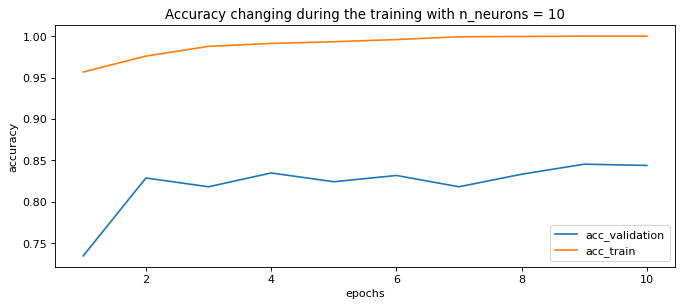

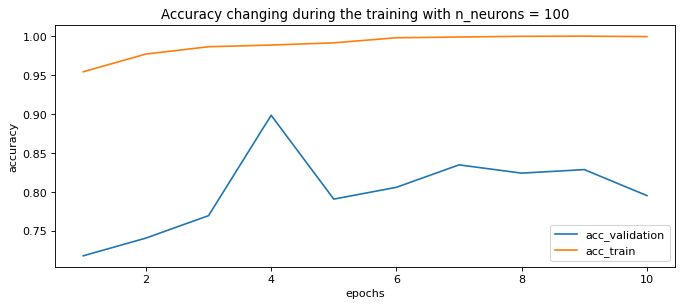

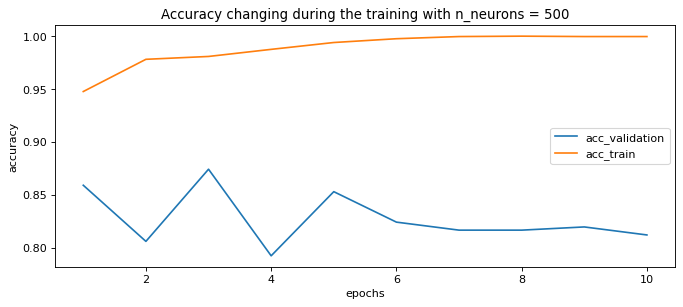

In [102]:
for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    acc_train = acc_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Accuracy changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')  
    plt.show()

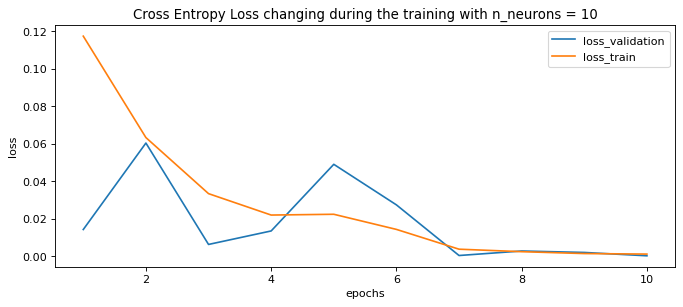

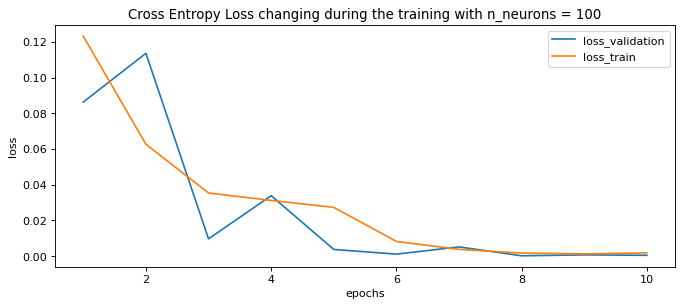

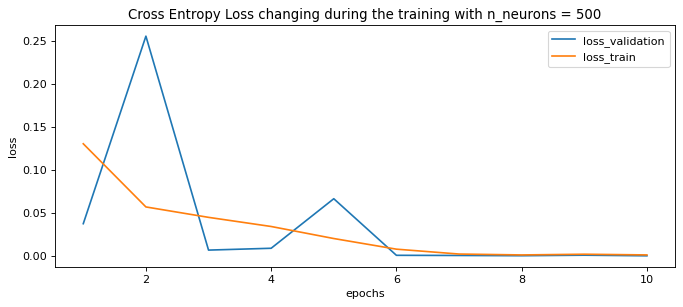

In [103]:
for i in n_neurons_list:
    loss_validation = loss_validation_dict[i]
    loss_train = loss_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Cross Entropy Loss changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
    plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='best')  
    plt.show()

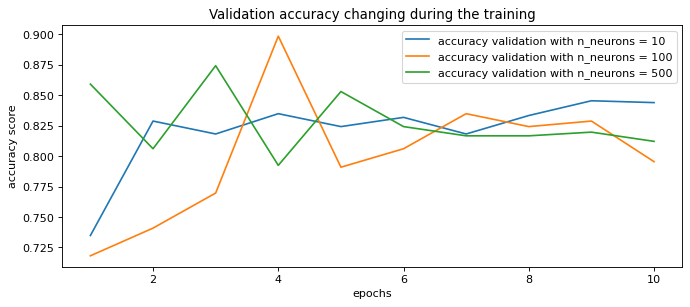

In [104]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Validation accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

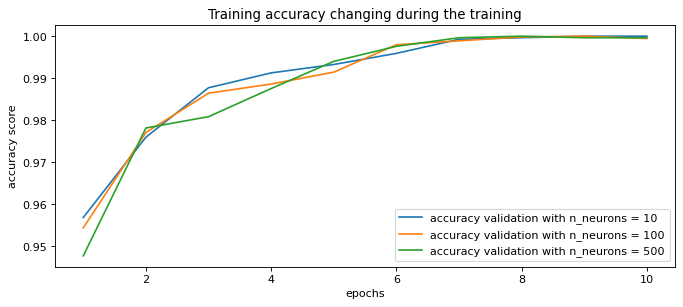

In [105]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Training accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_train = acc_train_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

In [106]:
table = [list(range(1,n_epoch+1))]
columns = ['epoch']
for i, val in enumerate(n_neurons_list):
    table.append(acc_validation_dict[val])
    columns.append(str(val)+' neurons')
table = np.asarray(table).T
print('Validation accuracy change:')
pd.DataFrame(table, columns=columns)

Validation accuracy change:


,epoch,10 neurons,100 neurons,500 neurons
0,1.0,0.734848,0.718182,0.859091
1,2.0,0.828788,0.740909,0.806061
2,3.0,0.818182,0.769697,0.874242
3,4.0,0.834848,0.898485,0.792424
4,5.0,0.824242,0.790909,0.853030
5,6.0,0.831818,0.806061,0.824242
6,7.0,0.818182,0.834848,0.816667
7,8.0,0.833333,0.824242,0.816667
8,9.0,0.845455,0.828788,0.819697
9,10.0,0.843939,0.795455,0.812121


In [107]:
acc_validation_dict_2 = acc_validation_dict
acc_train_dict_2 = acc_train_dict

Самый высокий показатель accuracy на валидации показал гиперпараметр 100 на 4 эпохе обучения. Так что загрузим именно эту модель:

In [108]:
n_neurons = 100
model_2 = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
# Переопределим первый сверточный слой сети, сделав 1 входной канал
model_2.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(512, n_neurons),
                nn.ReLU(),
                nn.Linear(n_neurons, 2))
model_2.fc = fc_new
wghts = torch.load(directory + '\model_ResNet18_2_n='+str(n_neurons)+'.pth')
model_2.load_state_dict(wghts.state_dict())

<All keys matched successfully>

Оценим качество этой модели на test:

In [109]:
model_2.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model_2(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        if i==0:
            y_true_list = label_batch.numpy()
            y_pred_list = predicted.numpy()
        else:
        
            y_true_list = np.concatenate([y_true_list, label_batch.numpy()])
            y_pred_list = np.concatenate([y_pred_list, predicted.numpy()])
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 90.94 %


In [110]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       129
           1       0.88      0.98      0.93       191

    accuracy                           0.91       320
   macro avg       0.93      0.89      0.90       320
weighted avg       0.92      0.91      0.91       320



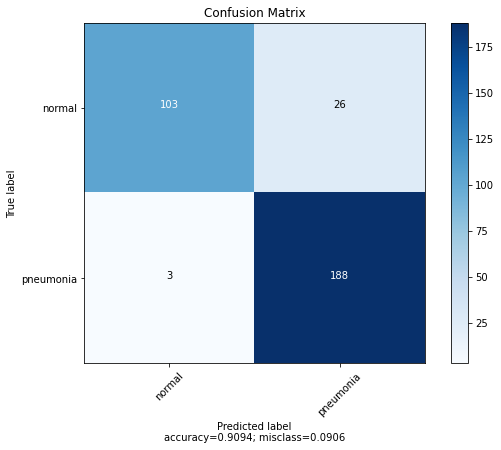

In [111]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['normal','pneumonia'],
                      title        = "Confusion Matrix")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


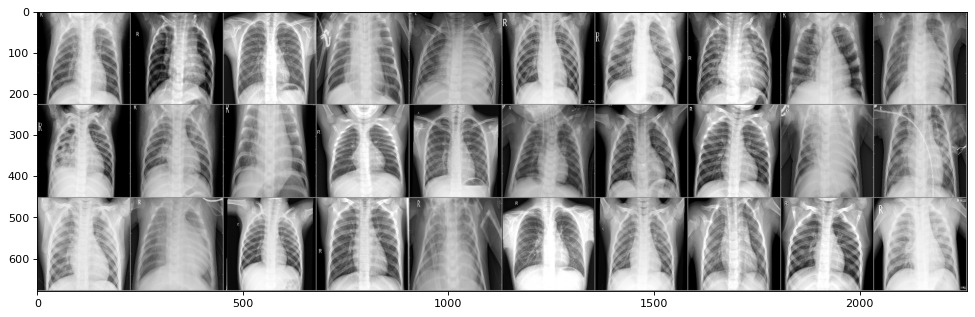

GroundTruth:  pneumonia pneumonia  norm pneumonia pneumonia  norm  norm pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia  norm  norm pneumonia pneumonia  norm pneumonia pneumonia  norm pneumonia  norm  norm pneumonia  norm  norm  norm  norm pneumonia
Прогноз:  pneumonia pneumonia norm pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia norm norm pneumonia pneumonia norm pneumonia pneumonia pneumonia pneumonia norm pneumonia pneumonia norm norm norm norm pneumonia


In [112]:
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(test_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ' '.join('%5s' % classes[int(label_batch[j])] for j in range(batch_size)))
outputs = model_2(image_batch)
predicted = torch.argmax(outputs, dim=1)

print('Прогноз: '," ".join(classes[predicted[j]]for j in range(batch_size)))

---

## №3

__Полностью обучим сеть, ничего в ней не меняя (кроме выходного числа нейронов в полносвязной части).__ <br>
Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

In [126]:
data = datasets_bilder.preprocessing_func(RGB_presentation=True, easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 30 
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [127]:
n_epoch = 15

In [128]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [129]:
model_3 = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)

# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
                nn.Linear(512, 2))
model_3.fc = fc_new
    
for name, param in model_3.named_parameters():
    param.requires_grad = True

loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

opt = optim.Adam(model_3.parameters(), lr=0.001) # Адам-оптимизатор
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)   

# Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
loss_train = []
acc_train = []
acc_validation = []
loss_validation = []

start_time = time.time()
maxacc = 0 
for epoch in range(n_epoch): # цикл эпох
    model_3.train() # Перевод модели в режим обучения
    running_loss = 0.0
    running_acc = 0.0
    for batch in tqdm(train_dataloader):
        # получим данные батча
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        #Приведу значение label_batch к требуемому виду
        label_batch = torch.flatten(label_batch).type(torch.LongTensor) 
        
        # обнуление параметров градиента
        opt.zero_grad()

        # forward + backward + optimize
        y_pred = model_3(image_batch)
        loss = loss_func(y_pred, label_batch)
        
        loss.backward()
        opt.step()
        
        #среднее по так будем искать (складывать а потом делить число батчей):
        running_loss += loss.item() 
        running_acc += accuracy(y_pred, label_batch)
        
    print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                      running_acc / len(train_dataloader)))
    loss_train.append(running_loss / len(train_dataloader))
    acc_train.append(running_acc / len(train_dataloader))
    scheduler.step() # шаг для lr_scheduler

    model_3.eval()  #Перевод модели в режим тестирования
    acc_val = []
    running_loss_val = 0
    for itr,data in enumerate(val_dataloader):
            imgs = data[0].to(device)
            labels = data[1].to(device)   
            labels = torch.flatten(labels).type(torch.LongTensor)
            y_pred = model_3(imgs)
            acc_val.append(accuracy(y_pred,labels))
            running_loss_val += loss.item()
    loss_val_ep =  running_loss_val / len(val_dataloader)

    acc_val_ep = np.mean(np.array(acc_val))
    print(f'Validation accuracy - {acc_val_ep}')
    acc_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)

    
    # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
    if np.mean(np.array(acc_val)) > maxacc:
            maxacc = np.mean(np.array(acc_val)) 
            torch.save(model_3, directory+'\model_ResNet18_full_train.pth')
            
print('Total time {:.3f} seconds'.format(time.time() - start_time))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [26:13<00:00,  8.79s/it]


[epoch 1] loss: 0.116, acc: 0.955
Validation accuracy - 0.8666666666666668


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [26:03<00:00,  8.73s/it]


[epoch 2] loss: 0.0503, acc: 0.98
Validation accuracy - 0.6984848484848484


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:58<00:00,  8.71s/it]


[epoch 3] loss: 0.0447, acc: 0.983
Validation accuracy - 0.7545454545454544


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:58<00:00,  8.71s/it]


[epoch 4] loss: 0.0207, acc: 0.992
Validation accuracy - 0.8515151515151516


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:54<00:00,  8.68s/it]


[epoch 5] loss: 0.0276, acc: 0.991
Validation accuracy - 0.787878787878788


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:53<00:00,  8.68s/it]


[epoch 6] loss: 0.00693, acc: 0.997
Validation accuracy - 0.8439393939393939


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:55<00:00,  8.69s/it]


[epoch 7] loss: 0.0031, acc: 1.0
Validation accuracy - 0.8257575757575757


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:51<00:00,  8.67s/it]


[epoch 8] loss: 0.00185, acc: 1.0
Validation accuracy - 0.8378787878787879


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:49<00:00,  8.66s/it]


[epoch 9] loss: 0.00118, acc: 1.0
Validation accuracy - 0.8424242424242423


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:51<00:00,  8.67s/it]


[epoch 10] loss: 0.000719, acc: 1.0
Validation accuracy - 0.8606060606060606


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:57<00:00,  8.70s/it]


[epoch 11] loss: 0.0006, acc: 1.0
Validation accuracy - 0.8621212121212121


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:51<00:00,  8.67s/it]


[epoch 12] loss: 0.000815, acc: 1.0
Validation accuracy - 0.8530303030303031


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:55<00:00,  8.69s/it]


[epoch 13] loss: 0.000741, acc: 1.0
Validation accuracy - 0.8530303030303031


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:57<00:00,  8.70s/it]


[epoch 14] loss: 0.000563, acc: 1.0
Validation accuracy - 0.8454545454545456


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:51<00:00,  8.67s/it]


[epoch 15] loss: 0.000484, acc: 1.0
Validation accuracy - 0.8454545454545456
Total time 24372.034 seconds


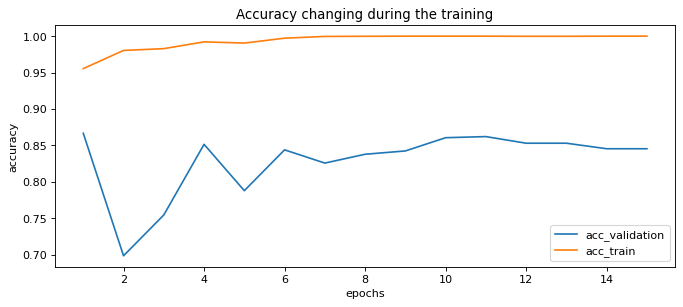

In [142]:
n_epoch = 15
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Accuracy changing during the training')  
plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')  
plt.show()

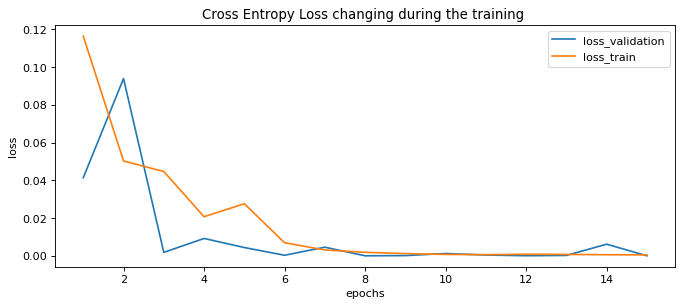

In [143]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Cross Entropy Loss changing during the training ')  
plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')  
plt.show()

Самый высокий показатель accuracy на валидации показала модель 4 эпохе обучения. Так что загрузим именно эту модель:

In [132]:
wghts = torch.load(directory + '\model_ResNet18_full_train.pth')
model_3.load_state_dict(wghts.state_dict())

<All keys matched successfully>

Оценим качество этой модели на test:

In [133]:
model_3.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model_3(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        if i==0:
            y_true_list = label_batch.numpy()
            y_pred_list = predicted.numpy()
        else:
        
            y_true_list = np.concatenate([y_true_list, label_batch.numpy()])
            y_pred_list = np.concatenate([y_pred_list, predicted.numpy()])
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 87.50 %


In [134]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       129
           1       0.84      0.98      0.90       191

    accuracy                           0.88       320
   macro avg       0.90      0.85      0.86       320
weighted avg       0.89      0.88      0.87       320



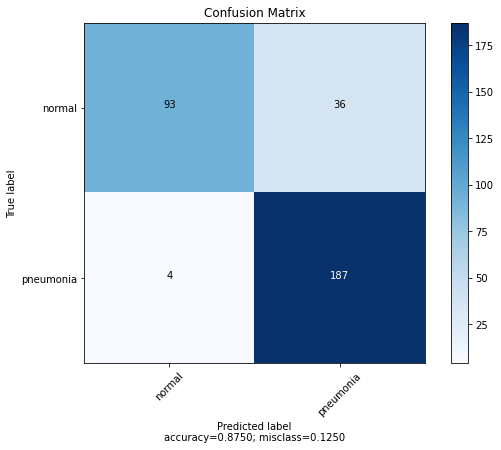

In [135]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['normal','pneumonia'],
                      title        = "Confusion Matrix")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


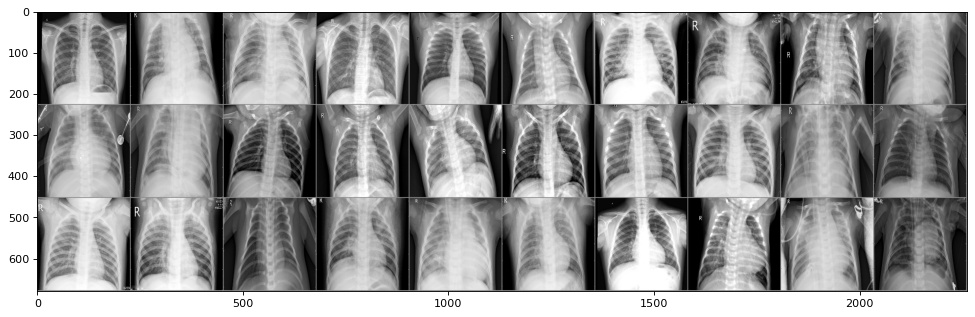

GroundTruth:   norm pneumonia pneumonia  norm  norm  norm pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia  norm  norm  norm  norm  norm pneumonia pneumonia pneumonia  norm pneumonia pneumonia pneumonia pneumonia pneumonia  norm pneumonia pneumonia pneumonia
Прогноз:  norm pneumonia pneumonia norm norm norm pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia norm norm norm norm norm pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia norm norm pneumonia pneumonia


In [136]:
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(test_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ' '.join('%5s' % classes[int(label_batch[j])] for j in range(batch_size)))
outputs = model_3(image_batch)
predicted = torch.argmax(outputs, dim=1)

print('Прогноз: '," ".join(classes[predicted[j]]for j in range(batch_size)))

In [144]:
acc_train_full = acc_train 
acc_validation_full = acc_validation 

### №3.1 Обучение полной модели без загрузки предобученных весов 

In [149]:
model_3 = resnet18(pretrained=False).to(device)
n_epoch = 10
# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
                nn.Linear(512, 2))
model_3.fc = fc_new
    
for name, param in model_3.named_parameters():
    param.requires_grad = True

loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

opt = optim.Adam(model_3.parameters(), lr=0.001) # Адам-оптимизатор
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)   

# Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
loss_train = []
acc_train = []
acc_validation = []
loss_validation = []

start_time = time.time()
maxacc = 0 
for epoch in range(n_epoch): # цикл эпох
    model_3.train() # Перевод модели в режим обучения
    running_loss = 0.0
    running_acc = 0.0
    for batch in tqdm(train_dataloader):
        # получим данные батча
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        #Приведу значение label_batch к требуемому виду
        label_batch = torch.flatten(label_batch).type(torch.LongTensor) 
        
        # обнуление параметров градиента
        opt.zero_grad()

        # forward + backward + optimize
        y_pred = model_3(image_batch)
        loss = loss_func(y_pred, label_batch)
        
        loss.backward()
        opt.step()
        
        #среднее по так будем искать (складывать а потом делить число батчей):
        running_loss += loss.item() 
        running_acc += accuracy(y_pred, label_batch)
        
    print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                      running_acc / len(train_dataloader)))
    loss_train.append(running_loss / len(train_dataloader))
    acc_train.append(running_acc / len(train_dataloader))
    scheduler.step() # шаг для lr_scheduler

    model_3.eval()  #Перевод модели в режим тестирования
    acc_val = []
    running_loss_val = 0
    for itr,data in enumerate(val_dataloader):
            imgs = data[0].to(device)
            labels = data[1].to(device)   
            labels = torch.flatten(labels).type(torch.LongTensor)
            y_pred = model_3(imgs)
            acc_val.append(accuracy(y_pred,labels))
            running_loss_val += loss.item()
    loss_val_ep =  running_loss_val / len(val_dataloader)

    acc_val_ep = np.mean(np.array(acc_val))
    print(f'Validation accuracy - {acc_val_ep}')
    acc_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)

    
    # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
    if np.mean(np.array(acc_val)) > maxacc:
            maxacc = np.mean(np.array(acc_val)) 
            torch.save(model_3, directory+'\model_ResNet18_no_TL.pth')
            
print('Total time {:.3f} seconds'.format(time.time() - start_time))

D:\Program files 2.0\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Program files 2.0\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:55<00:00,  8.69s/it]


[epoch 1] loss: 0.223, acc: 0.913
Validation accuracy - 0.7772727272727273


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:54<00:00,  8.68s/it]


[epoch 2] loss: 0.131, acc: 0.949
Validation accuracy - 0.7681818181818181


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:56<00:00,  8.69s/it]


[epoch 3] loss: 0.0974, acc: 0.962
Validation accuracy - 0.8181818181818182


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:56<00:00,  8.70s/it]


[epoch 4] loss: 0.079, acc: 0.971
Validation accuracy - 0.8424242424242425


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [25:57<00:00,  8.70s/it]


[epoch 5] loss: 0.0581, acc: 0.978
Validation accuracy - 0.8409090909090909


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [26:11<00:00,  8.78s/it]


[epoch 6] loss: 0.0234, acc: 0.993
Validation accuracy - 0.8151515151515152


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [26:10<00:00,  8.77s/it]


[epoch 7] loss: 0.0195, acc: 0.993
Validation accuracy - 0.7969696969696969


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [26:13<00:00,  8.79s/it]


[epoch 8] loss: 0.0158, acc: 0.995
Validation accuracy - 0.7848484848484848


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [26:26<00:00,  8.86s/it]


[epoch 9] loss: 0.0112, acc: 0.997
Validation accuracy - 0.8227272727272726


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [26:26<00:00,  8.86s/it]


[epoch 10] loss: 0.00796, acc: 0.997
Validation accuracy - 0.7954545454545454
Total time 16359.782 seconds


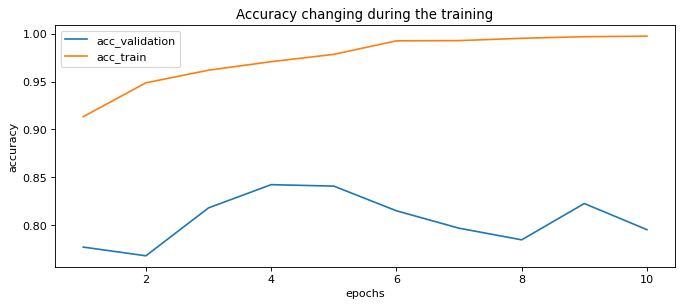

In [150]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Accuracy changing during the training')  
plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')  
plt.show()

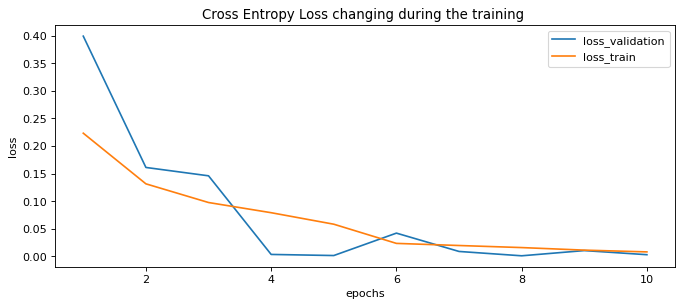

In [151]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Cross Entropy Loss changing during the training ')  
plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')  
plt.show()

In [169]:
wghts = torch.load(directory + '\model_ResNet18_no_TL.pth')
model_3.load_state_dict(wghts.state_dict())

<All keys matched successfully>

In [170]:
model_3.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model_3(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        if i==0:
            y_true_list = label_batch.numpy()
            y_pred_list = predicted.numpy()
        else:
        
            y_true_list = np.concatenate([y_true_list, label_batch.numpy()])
            y_pred_list = np.concatenate([y_pred_list, predicted.numpy()])
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 81.56 %


In [171]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.93      0.59      0.72       129
           1       0.78      0.97      0.86       191

    accuracy                           0.82       320
   macro avg       0.85      0.78      0.79       320
weighted avg       0.84      0.82      0.81       320



___

__Общеее сравнение ResNet Transfer Learning__

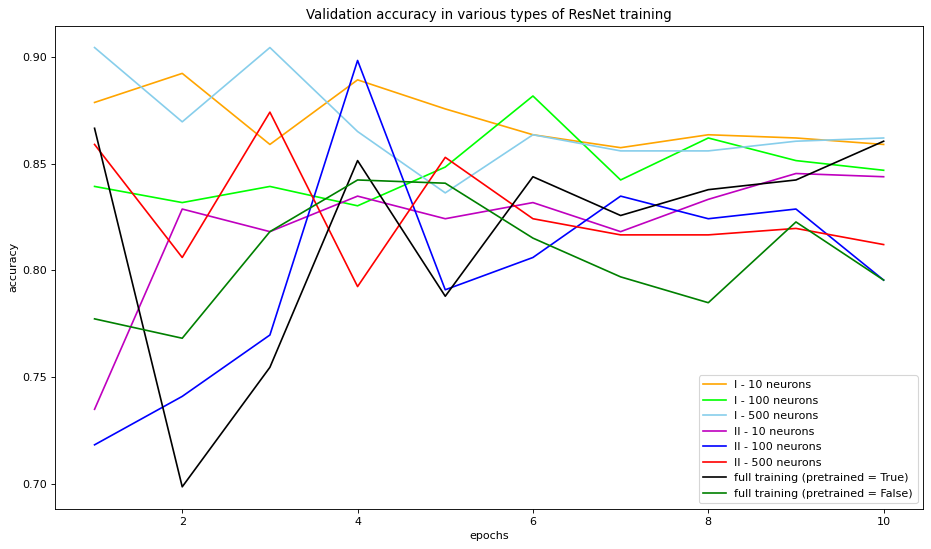

In [168]:
n_epoch = 10
plt.figure(figsize=(14, 8), dpi=80)
plt.title('Validation accuracy in various types of ResNet training')  
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_1[10], label='I - 10 neurons', color='orange')
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_1[100], label='I - 100 neurons',color='lime')
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_1[500], label='I - 500 neurons',color='skyblue')
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_2[10], label='II - 10 neurons',color='m')
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_2[100], label='II - 100 neurons',color='blue')
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_2[500], label='II - 500 neurons',color='red')
plt.plot(list(range(1, n_epoch+1)), acc_validation_full[:10] , label='full training (pretrained = True)',color='k')    
plt.plot(list(range(1, n_epoch+1)), acc_validation[:10] , label='full training (pretrained = False)',color='green') 
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')  
plt.show()

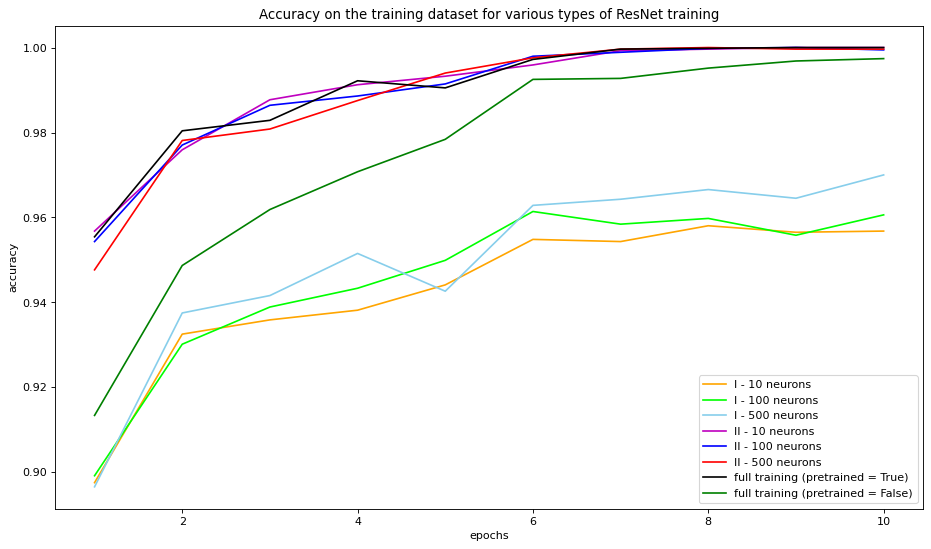

In [166]:
n_epoch = 10
plt.figure(figsize=(14, 8), dpi=80)
plt.title('Accuracy on the training dataset for various types of ResNet training')  
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_1[10], label='I - 10 neurons',  color='orange')
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_1[100], label='I - 100 neurons',color='lime')
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_1[500], label='I - 500 neurons',color='skyblue')
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_2[10], label='II - 10 neurons',color='m')
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_2[100], label='II - 100 neurons',color='blue')
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_2[500], label='II - 500 neurons',color='red')
plt.plot(list(range(1, n_epoch+1)), acc_train_full[:10] , label='full training (pretrained = True)',color='k')  
plt.plot(list(range(1, n_epoch+1)), acc_train[:10] , label='full training (pretrained = False)',color='green') 
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')  
plt.show()

### Вывод:
    

В данном проекте было проведено исследование применения transfer learning для решения задачи бинарной классификации рентгеновских снимков. В данном случае использовалась предобученная сеть ResNet18. Было проведено три эксперимента, в которых сравнивались результаты обучения при использовании разных подходов к переносу обучения<br>( 1 - мы обучали лишь полносвязную часть, 2 - полносвязную часть с первым сверточным слоем,  3 - обучали сеть целиком ) .<br><br>
В результате исследования было выявлено, что наилучшие результаты точности на тесте удалось добиться при использовании модели с измененным первым сверточным слоем и полносвязной частью с числом нейронов промежуточно слоя равному 100 (90% accuracy).
При этом все результаты точности на валидации для 7 моделей с применением Transfer Learning лежат в диапазоне от 80 до 90%. <br>При этом первый эксперимент при любых значениях гиперпараметра n_neurons ведет себя более стабильно на валидации и имеет низкую изменчивость относительно тренда в процессе обучения (при этом сами значения accuracy стабильно выше чем у всех остальных экспериментов). По этой причине можно сказать, что принцип обучения с фиксацией всех сверточных слоев показал более хорошие результаты чем все остальные рассмотренные подходы к обучению ResNet для данной бинарной классификации.<br> Так что такой высокий результат на тесте у второго эксперимента может быть вызван в том числе случайным стечением обстоятельств (тестовая выборка слишком мала чтобы считать разницу в 2% на accuracy статистически значимой) .<br>
<br>
Также было обнаружено, что использование предобученных весов значительно ускоряет скорость обучения. В эксперименте 3.1 я провел обучение сети ResNet18 без заранее подобранных весов и получил более длительное обучение на трейне а также более низкие показатели accuracy на валидации. Что подтверждает полезность использования технологии transfer learning - применение знаний, полученных при решении одной проблемы, для решения похожей.
<br><br>
Кроме того, было отмечено, что на 6-й эпохе обучения качество на валидации для большинства моделей выходило на плато и переставало скакать из-за случайных совпадений ответов. Однако, при использовании сети с очень большим числом нейронов промежуточного слоя на 9-й эпохе начиналось переобучение, что приводило к постепенной потере высокого качества.С ростом числа нейронов на скрытом слое полносвязной сети происходит возрастание скорости переобучения. Так что оптимальное значение эпох обучения напрямую зависит от этого гиперпараметра.<br><br>
При создании системы поддержки принятия врачебных решений важным праметром при оценке качества модели является f1 score и recall. Для нас важным является не пропустить пациентов с пневмонией и всех больных точно назвать больными. Для лучших моделей каждого из экспериментов были определены значения f1, recall и precision для класса 1 (наличие пневмонии). При анализе результатов эксперимента видно, что модель из второго эксперимента обладает самым высоким f1 score =  0.93 и recall = 0.98, в то время как другие 2 Transfer Learning модели f1 score = 0.90 (recall первого эксперимента 0.88, второго 0.98). Так как лучшая модель за эксперимент выбиралась по результату самого высокого accuracy на валидации в течение обучения, а в валидационной выборке преобладали фотографии 1 класса, поэтому высокие значения recall являются предсказуемыми, поэтому правильным будет вести оценку именно по f1 score.<br>
При обучении без предобученных весов сети (в эксперименте 3.1) мы получили самые низкие значения метрики f1 (0.86), что еще раз показывает преимущество переноса обучения в данной задаче классификации с небольшим размером train датасета.
<br><br>
Таким образом, данное исследование подтверждает эффективность использования transfer learning для решения задач машинного обучения, а также позволяет определить оптимальные параметры модели для достижения максимальной точности при минимальном переобучении.